# Biol 359A | Statistical tests and comparing data

### Spring 2025, Week 2

Objectives:
- Run and interpret a t-test
- Understand p-values and common pitfalls
- Gain intuition about statistical tests and sample sizes
- Fit lines to data

### Import statements

The packages used are as follows
- `pandas` provides dataframes for data storage and manipulation
- `ipywidgets` provides dynamic notebook widgets (like sliders)
- `scipy` us a general scientific computing package
- `numpy` is a general math/matrices package
- `matplotlib` Provides data visualization functionality
- `seaborn`: Data exploration visualization tool

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.stats as stats
import seaborn as sns

We will be working with real data today! The code below will clone the github repository storing the data and some bespoke data cleaning functions into the google colab environment for easy access. You can go to the website address if you'd like to see the github repo.

In [3]:
! rm -r week2_statisticaltests/
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr25/week2_statisticaltests.git
! cp -r week2_statisticaltests/* .
! ls

rm: cannot remove 'week2_statisticaltests/': No such file or directory
Cloning into 'week2_statisticaltests'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 22 (delta 7), reused 22 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 357.67 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (7/7), done.
clean_data.py  README.md    statistical_tests.ipynb  xkcd_jelly_beans.png
data	       sample_data  week2_statisticaltests


## Hypothesis Testing Overview:

Hypothesis testing is a method used to decide whether there is enough evidence to reject the null hypothesis.

### Key Concepts and Steps:

1. **Null Hypothesis ($H_0$):** This is our starting assumption, which typically suggests no effect or no difference. In mathematical terms, we express it as $H_0: \bar{X} = \mu$, where $\bar{X}$ is the sample mean, and $\mu$ is the population mean we're comparing to.

2. **Alternative Hypothesis ($H_a$):** This represents the alternative belief, essentially what we suspect might be true instead of the null hypothesis. It's expressed as $H_A: \bar{X} \neq \mu$ for a two-sided test, or $H_A: \bar{X} > \mu$ or $H_A: \bar{X} < \mu$ for one-sided tests. This hypothesis suggests there is an effect or a difference.

3. **Test Statistic:** A numerical value calculated from the sample data, used to decide whether to reject H₀. It measures how far the observed data diverges from the null hypothesis.

4. **Null Distribution:** This is the probability distribution of the test statistic under the assumption that the null hypothesis is true.

5. **P-value:** The p-value is the probability of observing a test statistic as extreme as, or more extreme than, the observed result, under the assumption that the null hypothesis is true. It quantifies how unusual our data is if $H_0$ were true. A low p-value indicates that such data would be very unlikely under the null hypothesis, suggesting evidence against $H_0$.

6. **Significance Level (α):** Before conducting the test, we choose a significance level (often 0.05), which is the threshold used to decide whether the p-value is low enough to reject the null hypothesis. If the p-value is less than $\alpha$, we reject $H_0$, concluding that our results are statistically significant.


In hypothesis testing, the choice of test hinges on the comparison you're making (e.g., group differences, variable relationships, time changes) and your data's characteristics (distribution type, independence, measurement scale, sample size). Two common tests to assess mean similarity are Student's t-test and Welch's t-test

#### Student's t-test (Two-sample t-test):

The Student's t-test is used to compare the means of two groups to see if they are statistically different from each other. It assumes that the two samples are independently and randomly drawn, the data is continuous and approximately normally distributed, and the two populations have equal variances.

- **Equation:** The test statistic for the Student's t-test is calculated as:

  $$t = \frac{\bar{x}_1 - \bar{x}_2}{s_p\sqrt{\frac{2}{n}}}$$

  where $\bar{x}_1$ and $\bar{x}_2$ are the sample means, $s_p$ is the pooled standard deviation, and $n$ is the sample size (assuming equal size for simplicity).

- **Types of Student's t-test:**
  - **Independent samples t-test:** Compares the means of two independent groups.
  - **Paired sample t-test:** Compares means from the same group at different times or under different conditions.
  
- **Null Distribution:** The test statistic follows a Student's t-distribution under the null hypothesis. The Student's t-distribution is similar to the normal distribution but with heavier tails. The shape of the t-distribution is determined by its degrees of freedom (df), which is typically the sample size - 1. With fewer degrees of freedom (smaller sample sizes), the t-distribution has heavier tails, indicating a higher probability of values further from the mean, reflecting the increased uncertainty in estimates from smaller samples. See the plot of the Student's t-distribution for different degrees of freedom plotted below.

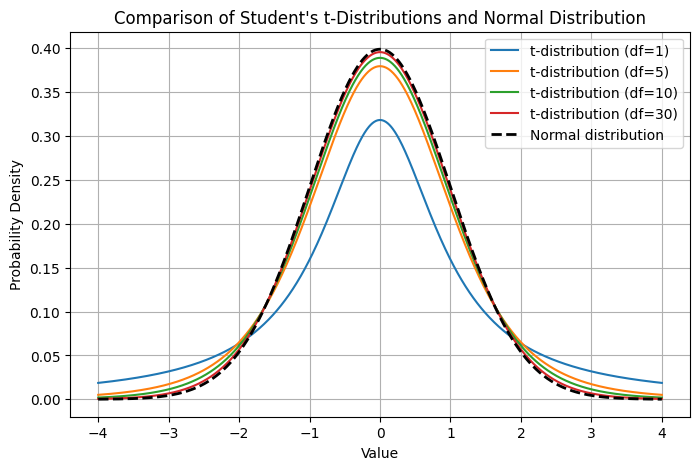

In [4]:
# Define the degrees of freedom
dfs = [1, 5, 10, 30]

# Plot t-distributions with different degrees of freedom
x = np.linspace(-4, 4, 1000)
plt.figure(figsize=(8, 5))

for df in dfs:
    plt.plot(x, stats.t.pdf(x, df), label=f't-distribution (df={df})')

# Plot the standard normal distribution for comparison
plt.plot(x, stats.norm.pdf(x), 'k--', linewidth=2, label='Normal distribution')

plt.title('Comparison of Student\'s t-Distributions and Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


## Exploring real data

For today's lesson we will be working on real breast cancer data from the[ Wisconsin Diagnostic Breast Cancer Database (WDBC)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).

Here is a summary of the data from the data source:
```
	Features are computed from a digitized image of a fine needle
	aspirate (FNA) of a breast mass.  They describe
	characteristics of the cell nuclei present in the image.
	A few of the images can be found at
	http://www.cs.wisc.edu/~street/images/

	Separating plane described above was obtained using
	Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree
	Construction Via Linear Programming." Proceedings of the 4th
	Midwest Artificial Intelligence and Cognitive Science Society,
	pp. 97-101, 1992], a classification method which uses linear
	programming to construct a decision tree.  Relevant features
	were selected using an exhaustive search in the space of 1-4
	features and 1-3 separating planes.

	The actual linear program used to obtain the separating plane
	in the 3-dimensional space is that described in:
	[K. P. Bennett and O. L. Mangasarian: "Robust Linear
	Programming Discrimination of Two Linearly Inseparable Sets",
	Optimization Methods and Software 1, 1992, 23-34].

	This database is also available through the UW CS ftp server:
	ftp ftp.cs.wisc.edu
	cd math-prog/cpo-dataset/machine-learn/WDBC/
    
    Source:
    W.N. Street, W.H. Wolberg and O.L. Mangasarian
	Nuclear feature extraction for breast tumor diagnosis.
	IS&T/SPIE 1993 International Symposium on Electronic Imaging: Science
	and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.
```

What do all the column names mean?

- ID number
- Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1) - a measure of "complexity" of a 2D image.


Cateogory Distribution: 357 benign, 212 malignant

We will import and clean these data using another python script called clean_data.py. That script loads the data into a pandas dataframe and removes part of the dataset we will not be using:

In [6]:
import clean_data

cancer_dataset = clean_data.generate_clean_dataframe()
cancer_dataset

,,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension
ID,diagnosis,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883
...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648


We can now use pandas dataframe functions to explore the data.

If we want to show the first five values in some column in the table:

In [8]:
cancer_dataset["mean_area"].head()

,,mean_area
ID,diagnosis,
842302,M,1001.0
842517,M,1326.0
84300903,M,1203.0
84348301,M,386.1
84358402,M,1297.0


If we want to show the first five values for each diagnosis category:

In [9]:
cancer_dataset["mean_area"].groupby("diagnosis").head()

,,mean_area
ID,diagnosis,
842302,M,1001.0
842517,M,1326.0
84300903,M,1203.0
84348301,M,386.1
84358402,M,1297.0
8510426,B,566.3
8510653,B,520.0
8510824,B,273.9
854941,B,523.8


We can use the `pandas` package for calculating summary statistics:

In [10]:
cancer_dataset["mean_area"].describe()

,mean_area
count,569.000000
mean,654.889104
std,351.914129
min,143.500000
25%,420.300000
50%,551.100000
75%,782.700000
max,2501.000000


## Formulating hypotheses

To further our understanding of cancer, we aim to identify which characteristics, or features, of cell nuclei differ significantly between cancerous (malignant) and healthy (benign) tissue. Insight into these distinctions could enhance diagnostic techniques and/or generate hypotheses regarding the onset and advancement of cancer.

The following Python code generates box plots to compare the distributions of various measured nuclear features between malignant and benign cells. Box plots are invaluable for such comparisons because they succinctly summarize data distributions. Here's a brief guide to understanding the components of a box plot:

- The Box: Represents the interquartile range (IQR), capturing the middle 50 percent of the data. The bottom and top of the box mark the first (Q1) and third (Q3) quartiles, respectively, and the line inside the box identifies the median.
- The Whiskers: Extend from the box to show the range of the data, adjusted for potential outliers. Typically, they span from Q1 - 1.5IQR to Q3 + 1.5IQR.
- Outliers: Here depicted as circles, these points lie outside the range covered by the whiskers, indicating data points that are unusually high or low.
- The Diamond: Represents the mean of the data, providing a point of central tendency.

By selecting different features from the dropdown menu, you can explore the distribution of data for each nuclear characteristic across malignant and benign cells. This visual exploration can reveal how certain nuclear features vary between cancerous and non-cancerous cells, potentially highlighting factors critical to the diagnosis or understanding of cancer.

In [15]:
cancer_dataset_reset = cancer_dataset.reset_index()
cancer_dataset_reset.columns = ['ID', 'Diagnosis'] + list(cancer_dataset_reset.columns[2:])

def plot_column(column):
    # Define colors for consistent use in plots
    colors = {'B': 'skyblue', 'M': 'salmon'}

    # Calculate summary statistics for each diagnosis
    ordered_diagnoses = ['M', 'B']
    diagnoses_abbr_name = {'M':'malignant', 'B': 'benign'}
    stats_df = cancer_dataset_reset.groupby('Diagnosis')[column].describe().reindex(ordered_diagnoses)

    # Plotting
    plt.figure(figsize=(10, 4))

    # Plot boxplot
    sns.boxplot(y='Diagnosis', x=column, hue='Diagnosis', data=cancer_dataset_reset, orient='h', palette=colors, dodge=False)
    plt.title(f'Box plot of {column} by Diagnosis')
    plt.ylabel('Diagnosis')
    plt.xlabel(column)

    # Plot the mean as a black diamond ('D')
    means = cancer_dataset_reset.groupby('Diagnosis')[column].mean().reindex(ordered_diagnoses)
    for diagnosis, mean in means.items():
        y_pos = ordered_diagnoses.index(diagnosis)
        label = f'Mean {diagnoses_abbr_name[diagnosis]}'
        plt.plot(mean, y_pos, 'D', color='black', markersize=3, label=label)

    # Display summary statistics table below the boxplot
    table_ax = plt.table(cellText=stats_df.round(2).values,
                         colLabels=stats_df.columns,
                         rowLabels=stats_df.index,
                         cellLoc='center', rowLoc='center',
                         loc='bottom', bbox=[0, -0.5, 1, 0.3])
    plt.legend()
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.show()

# Create a dropdown menu for selecting the column to plot
dropdown_columns = widgets.Dropdown(
    options=[col for col in cancer_dataset_reset.columns if col not in ['ID', 'Diagnosis']],
    description='Column:',
    disabled=False,
)

# Display the dropdown and plot the selected column
_ = widgets.interact(plot_column, column=dropdown_columns)


interactive(children=(Dropdown(description='Column:', options=('mean_radius', 'mean_texture', 'mean_perimeter'…

### Student's T-Test

The code below allows you to select a nuclear characteristic and see both box plots and the probability density distributions of that characteristic for malignant and benign cells. Below these visualizations is the p-value for that characteristic calculated using Student's t-test.

In [16]:
cancer_dataset_reset = cancer_dataset.reset_index()
cancer_dataset_reset.columns = ['ID', 'Diagnosis'] + list(cancer_dataset_reset.columns[2:])

def plot_column(column):
    # Define colors for consistent use in plots
    colors = {'B': 'skyblue', 'M': 'salmon'}

    # Setup the figure and axes for the two plots
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Plot probability density functions on the first subplot
    for diagnosis in ['M', 'B']:
        subset = cancer_dataset_reset[cancer_dataset_reset['Diagnosis'] == diagnosis]
        sns.kdeplot(data=subset, x=column, ax=axes[0], fill=True, alpha=0.5, linewidth=2, label=diagnosis, color=colors[diagnosis])
    axes[0].legend(['Malignant', 'Benign'])
    axes[0].set_title(f'Probability Density of {column}')

    # Perform Student's t-test
    t_statistic_student, p_value_student = stats.ttest_ind(
        cancer_dataset_reset[cancer_dataset_reset['Diagnosis'] == 'M'][column],
        cancer_dataset_reset[cancer_dataset_reset['Diagnosis'] == 'B'][column],
        equal_var=True
    )


    # Plot boxplot
    sns.boxplot(y='Diagnosis', x=column, hue='Diagnosis', data=cancer_dataset_reset, orient='h', ax=axes[1], palette=colors, dodge=False)
    axes[1].set_title(f'Box Plot of {column} by Diagnosis')
    # Plot the mean as a black diamond ('D')
    ordered_diagnoses = ['M', 'B']
    means = cancer_dataset_reset.groupby('Diagnosis')[column].mean().reindex(ordered_diagnoses)
    for diagnosis, mean in means.items():
        y_pos = ordered_diagnoses.index(diagnosis)
        plt.plot(mean, y_pos, 'D', color='black', markersize=3)

    # Display p-values at the bottom of the plot
    p_value_text = f"Student's t-test p-value: {p_value_student:.3e}"
    plt.figtext(0.5, -0.05, p_value_text, fontsize=10, ha='center', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

    # Fine-tune layout
    plt.tight_layout()
    plt.show()

# Create a dropdown menu for selecting the column to plot
dropdown_columns = widgets.Dropdown(
    options=[col for col in cancer_dataset_reset.columns if col not in ['ID', 'Diagnosis']],
    description='Column:',
    disabled=False,
)

# Display the dropdown and plot the selected column
_ =widgets.interact(plot_column, column=dropdown_columns)

interactive(children=(Dropdown(description='Column:', options=('mean_radius', 'mean_texture', 'mean_perimeter'…

DISCUSSION QUESTION:
- Which feature(s) can be used to differentiate benign and malignant breast tumor?
- In clinical practice, additional tests like histopathology, whole genome sequencing (WGS), or single-cell RNA sequencing (scRNA-seq) are often required for a comprehensive diagnosis. Given these limitations, what is the role or value of FNA-derived image features in the clinical decision-making process? 

### Sample size and p-hacking

So we've compared the data based on all of the available data, but what if we were limited in the samples that we were able to collect? We will consider what happens to our comparisons and tests if we are only able to see a subsample of the available data. There are multiple things to consider here but there are two main ideas that drive the concept of _p_-hacking.

  1) Intuitively, more samples give you more information about your population.
  
  2) More samples also reduce your p-values, potentially assigning "significance" to a potentially trivial effect.

The code below prepares an interactive visualization where you can select a nuclear characteristic and a sample size. The code randomly samples the selected number of samples from each population and displays the resulting distributions and Student's and Welch's t-test p-values. Explore sample size to gain an intuition for how changing sample size affects distributions and t-test p-values.

In [18]:
cancer_dataset_reset = cancer_dataset.reset_index()
cancer_dataset_reset.columns = ['ID', 'Diagnosis'] + list(cancer_dataset_reset.columns[2:])

def plot_column(column, n_samples):
    # Define colors for consistent use in plots
    colors = {'B': 'skyblue', 'M': 'salmon'}

    # Sample n datapoints from the full dataset
    sampled_data = cancer_dataset_reset.sample(n=n_samples, random_state=42)

    # Setup the figure and axes for the two plots
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Plot probability density functions on the first subplot for the sampled data
    for diagnosis in ['M', 'B']:
        subset = sampled_data[sampled_data['Diagnosis'] == diagnosis]
        sns.kdeplot(data=subset, x=column, ax=axes[0], fill=True, alpha=0.5, linewidth=2, label=diagnosis, color=colors[diagnosis])
    axes[0].legend(['Malignant', 'Benign'])
    axes[0].set_title(f'Probability Density of {column} (Sampled Data)')

    # Perform Student's t-test for the sampled data
    t_statistic_student, p_value_student = stats.ttest_ind(
        sampled_data[sampled_data['Diagnosis'] == 'M'][column],
        sampled_data[sampled_data['Diagnosis'] == 'B'][column],
        equal_var=True
    )

    # Plot boxplot
    sns.boxplot(y='Diagnosis', x=column, hue='Diagnosis', data=cancer_dataset_reset, orient='h', ax=axes[1], palette=colors, dodge=False)
    axes[1].set_title(f'Box Plot of {column} by Diagnosis')
    # Plot the mean as a black diamond ('D')
    ordered_diagnoses = ['M', 'B']
    means = cancer_dataset_reset.groupby('Diagnosis')[column].mean().reindex(ordered_diagnoses)
    for diagnosis, mean in means.items():
        y_pos = ordered_diagnoses.index(diagnosis)
        plt.plot(mean, y_pos, 'D', color='black', markersize=3)

    # Display p-values at the bottom of the plot
    p_value_text = f"Student's t-test p-value: {p_value_student:.3e}"
    plt.figtext(0.5, -0.05, p_value_text, fontsize=10, ha='center', va='center', bbox=dict(facecolor='lightgray', alpha=0.5))

    # Fine-tune layout
    plt.tight_layout()
    plt.show()

# Create a dropdown menu for selecting the column to plot
dropdown_columns = widgets.Dropdown(
    options=[col for col in cancer_dataset.columns if col not in ['ID', 'Diagnosis']],
    description='Column:',
    disabled=False,
)

# Create a slider for selecting the number of data points (n) to sample
n_slider = widgets.IntSlider(value=30, min=10, max=len(cancer_dataset), step=1, description='Sample Size:', disabled=False)

# Display the dropdown, slider, and plot the selected column with sampled data
_ = widgets.interact(plot_column, column=dropdown_columns, n_samples=n_slider)

interactive(children=(Dropdown(description='Column:', options=('mean_radius', 'mean_texture', 'mean_perimeter'…

### P-Values and Correlation

P-values are also calculated for correlation coefficients. The code below generates an interactive visualization where you can plot two nuclear features against each other and calculate the spearman and pearson correlation coefficients for each. Explore the data to see which features seem correlated and which do not. Observe the calculated correlation coefficients and the resulting p-values.

In [19]:
def plot_correlation(feature1, feature2):
    # Calculate Pearson correlation coefficient and its p-value
    pearson_corr, pearson_p_value = stats.pearsonr(cancer_dataset[feature1], cancer_dataset[feature2])

    # Calculate Spearman correlation coefficient and its p-value
    spearman_corr, spearman_p_value = stats.spearmanr(cancer_dataset[feature1], cancer_dataset[feature2])

    # Plot the scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=cancer_dataset, x=feature1, y=feature2)
    plt.title(f'{feature1} vs {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)

    # Display correlation coefficients and p-values
    plt.text(1.02, 0.5, f'Pearson Correlation: {pearson_corr:.3f}\n(P-value: {pearson_p_value:.3e})', transform=plt.gca().transAxes, fontsize=12, va='center', ha='left')
    plt.text(1.02, 0.4, f'Spearman Correlation: {spearman_corr:.3f}\n(P-value: {spearman_p_value:.3e})', transform=plt.gca().transAxes, fontsize=12, va='center', ha='left')

    plt.show()

# Create dropdown menus for selecting the features
feature1_dropdown = widgets.Dropdown(options=cancer_dataset.columns, description='Feature 1:')
feature2_dropdown = widgets.Dropdown(options=cancer_dataset.columns, description='Feature 2:')

# Display dropdown menus and plot the selected features against each other
_ = widgets.interact(plot_correlation, feature1=feature1_dropdown, feature2=feature2_dropdown)

interactive(children=(Dropdown(description='Feature 1:', options=('mean_radius', 'mean_texture', 'mean_perimet…

DISCUSSION QUESTION:
- Does anything about these p values surprise you?

### XKCD Comic Aside:

Run the code below to see a very relevant XKCD comic! [source](https://www.explainxkcd.com/wiki/index.php/882:_Significant)

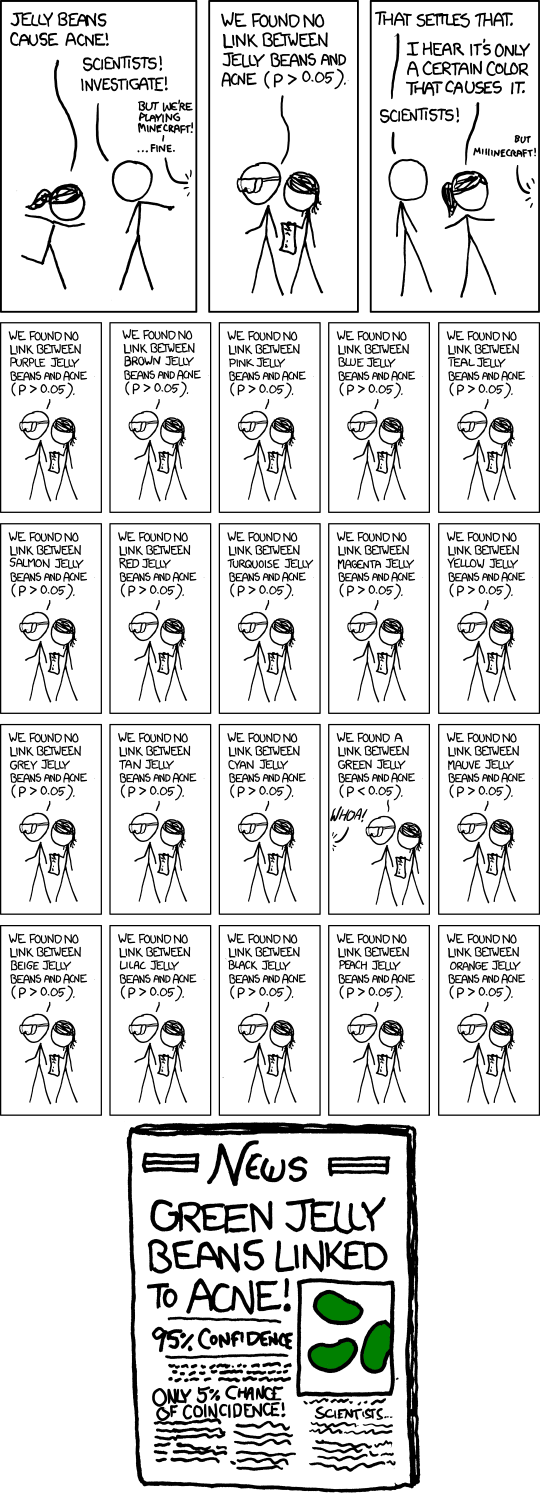

In [20]:
from IPython import display
display.Image("xkcd_jelly_beans.png")

DISCUSSION QUESTION:
- How many different colors of jelly beans did the scientists need to test in order to find a color the correlated significantly with acne? Why did it take that many colors to find a significant correlation?